In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.special import expit as sigmoid
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

##South African Heart Dataset

In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.special import expit as sigmoid

df = pd.read_csv("saheart_1 withheader.csv")
df["CLASS"] = df["CLASS"].replace({-1: 0})

n_repeats = 50
k_val = 5
lambda_k = 0.01

lasso_alphas = np.logspace(-4, 1, 20)
enet_alphas = np.logspace(-4, 1, 10)
enet_l1_ratios = [0.1, 0.5, 0.7, 0.9]

results = {
    "Lasso": {"mse": [], "acc": []},
    "ElasticNet": {"mse": [], "acc": []},
    "k-support": {"mse": [], "acc": []}
}

# === Custom prox and K-Support Class ===
def prox(v, L, k):
    original = np.array(v)
    sorted_indices = np.argsort(-np.abs(original))
    sorted_abs = np.abs(original)[sorted_indices]
    signs = np.sign(original)[sorted_indices]

    z = sorted_abs.tolist()
    d = len(z)
    z.append(-np.inf)
    z = [np.inf] + z

    for r in range(k):
        for l in range(k, d + 1):
            T_r_l = sum(z[k - r:l + 1])
            if T_r_l < (z[k - r - 1] * (l - k + (L + 1) * r + L + 1)) / (L + 1) and \
               T_r_l >= (z[k - r] * (l - k + (L + 1) * r + L + 1)) / (L + 1):
                if z[l] > T_r_l / (l - k + (L + 1) * r + L + 1) and \
                   T_r_l / (l - k + (L + 1) * r + L + 1) >= z[l + 1]:
                    q = np.zeros(d + 2)
                    for i in range(1, k - r):
                        q[i] = (L * z[i]) / (L + 1)
                    for i in range(k - r, l + 1):
                        q[i] = z[i] - (T_r_l / (l - k + (L + 1) * r + L + 1))
                    for i in range(l + 1, d + 1):
                        q[i] = 0
                    q = q[1:d + 1]
                    processed_with_sign = np.array(q) * signs
                    reconstructed = np.empty_like(original)
                    reconstructed[sorted_indices] = processed_with_sign
                    return reconstructed
    return np.zeros_like(v)

class K_Support_Norm:
    def fit(self, X_train, y_train, k, lambd):
        X_train = np.insert(X_train, 0, 1, axis=1)
        alpha = np.ones(X_train.shape[1])
        w = np.ones(X_train.shape[1])
        w_new = [1.1] * len(w)
        theta = 1
        sigma_max = np.linalg.norm(X_train, ord=2)
        L = 0.25*sigma_max ** 2
        count = 0
        while np.linalg.norm(w_new - w) > 1e-6:
            if count != 0:
                w = w_new
            if count == 10000:
                break
            theta_new = (1 + np.sqrt(1 + 4 * theta ** 2)) / 2
            grad = np.dot(X_train.T, sigmoid(np.dot(X_train, alpha.T)) - y_train)
            w_new = prox(alpha - (1 / L) * grad, L / lambd, k)
            alpha_new = w_new + ((theta - 1) / theta_new) * (w_new - w)
            alpha = alpha_new
            theta = theta_new
            count += 1
        self.intercept = w_new[0]
        self.coef_ = w_new[1:]

    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept

# === Main Loop ===
for _ in range(n_repeats):
    data = df.sample(frac=1).reset_index(drop=True)
    X = data.drop(columns=["CLASS"]).values
    y = data["CLASS"].values

    X_train, X_val, X_test = X[:400], X[400:430], X[430:462]
    y_train, y_val, y_test = y[:400], y[400:430], y[430:462]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    X_tv = np.vstack([X_train, X_val])
    y_tv = np.concatenate([y_train, y_val])

    # ----- Lasso -----
    best_alpha = min(lasso_alphas, key=lambda a: mean_squared_error(
        y_val, Lasso(alpha=a, max_iter=10000).fit(X_train, y_train).predict(X_val)))
    model = Lasso(alpha=best_alpha, max_iter=10000).fit(X_tv, y_tv)
    y_pred = model.predict(X_test)
    results["Lasso"]["mse"].append(mean_squared_error(y_test, y_pred))
    results["Lasso"]["acc"].append(accuracy_score(y_test, (y_pred >= 0.5).astype(int)))

    # ----- Elastic Net -----
    best_params = (0, 0)
    best_mse = float("inf")
    for a in enet_alphas:
        for r in enet_l1_ratios:
            model = ElasticNet(alpha=a, l1_ratio=r, max_iter=10000).fit(X_train, y_train)
            mse = mean_squared_error(y_val, model.predict(X_val))
            if mse < best_mse:
                best_params, best_mse = (a, r), mse
    model = ElasticNet(alpha=best_params[0], l1_ratio=best_params[1], max_iter=10000).fit(X_tv, y_tv)
    y_pred = model.predict(X_test)
    results["ElasticNet"]["mse"].append(mean_squared_error(y_test, y_pred))
    results["ElasticNet"]["acc"].append(accuracy_score(y_test, (y_pred >= 0.5).astype(int)))

    # ----- K-Support -----
    kmodel = K_Support_Norm()
    kmodel.fit(X_tv, y_tv, k=k_val, lambd=lambda_k)
    y_pred = sigmoid(kmodel.predict(X_test))
    results["k-support"]["mse"].append(mean_squared_error(y_test, y_pred))
    results["k-support"]["acc"].append(accuracy_score(y_test, (y_pred >= 0.5).astype(int)))

# === Results Table ===
summary = {
    "Method": [],
    "MSE (median)": [],
    "MSE (SE)": [],
    "Accuracy (median)": [],
    "Accuracy (SE)": []
}

for method in results:
    summary["Method"].append(method)
    summary["MSE (median)"].append(np.median(results[method]["mse"]))
    summary["MSE (SE)"].append(np.std(results[method]["mse"]) / np.sqrt(n_repeats))
    summary["Accuracy (median)"].append(np.median(results[method]["acc"]))
    summary["Accuracy (SE)"].append(np.std(results[method]["acc"]) / np.sqrt(n_repeats))

df_final = pd.DataFrame(summary)
print("Final Combined Results (50 Repeats):")
print(df_final.to_string(index=False))

Final Combined Results (50 Repeats):
    Method  MSE (median)  MSE (SE)  Accuracy (median)  Accuracy (SE)
     Lasso      0.181076  0.004876            0.71875       0.010644
ElasticNet      0.181135  0.004869            0.71875       0.011105
 k-support      0.179434  0.005210            0.71875       0.010514


## Synthetic Dataset

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define the proximal operator for k-support norm
def prox(v, L, k):
    original = np.array(v)
    sorted_indices = np.argsort(-np.abs(original))
    sorted_abs = np.abs(original)[sorted_indices]
    signs = np.sign(original)[sorted_indices]
    z = sorted_abs.tolist()
    d = len(z)
    z.append(-np.inf)
    z = [np.inf] + z
    for r in range(k):
        for l in range(k, d + 1):
            T_r_l = sum(z[k - r:l + 1])
            if T_r_l < (z[k - r - 1] * (l - k + (L + 1) * r + L + 1)) / (L + 1) and T_r_l >= (z[k - r] * (l - k + (L + 1) * r + L + 1)) / (L + 1):
                if z[l] > T_r_l / (l - k + (L + 1) * r + L + 1) and T_r_l / (l - k + (L + 1) * r + L + 1) >= z[l + 1]:
                    q = np.zeros(d + 2)
                    for i in range(1, k - r):
                        q[i] = (L * z[i]) / (L + 1)
                    for i in range(k - r, l + 1):
                        q[i] = z[i] - (T_r_l / (l - k + (L + 1) * r + L + 1))
                    for i in range(l + 1, d + 1):
                        q[i] = 0
                    q = q[1:d + 1]
                    processed_with_sign = np.array(q) * signs
                    reconstructed = np.empty_like(original)
                    reconstructed[sorted_indices] = processed_with_sign
                    return reconstructed
    return original

# Define k-support norm regression class
class K_Support_Norm:
    def fit(self, X_train, y_train, k, lambd):
        alpha = np.zeros(X_train.shape[1])
        w = np.zeros(X_train.shape[1])
        w_new = np.ones(X_train.shape[1]) * 1.1
        theta = 1
        sigma_max = np.linalg.norm(X_train, ord=2)
        L = sigma_max ** 2
        count = 0
        while np.linalg.norm(w_new - w) > 0.000001:
            if count != 0:
                w = w_new
            if count == 10000:
                break
            theta_new = (1 + np.sqrt(1 + 4 * theta ** 2)) / 2
            w_new = prox(alpha - (1 / L) * np.dot(X_train.T, np.dot(X_train, alpha) - y_train), L / lambd, k)
            alpha_new = w_new + ((theta - 1) / theta_new) * (w_new - w)
            alpha = alpha_new
            theta = theta_new
            count += 1
        self.coef_ = w_new

    def predict(self, X_test):
        return np.dot(X_test, self.coef_)

# Parameters
n_datasets = 50
n_train, n_val, n_test = 50, 50, 350
p = 40
w_star = np.zeros(p)
w_star[:15] = 3

# Generate datasets with correlated structure
def generate_X(n_samples):
    cov_block = np.full((5, 5), 0.5)
    np.fill_diagonal(cov_block, 1)
    X = np.zeros((n_samples, p))
    for i in range(3):  # Three correlated blocks of 5
        X[:, 5*i:5*(i+1)] = np.random.multivariate_normal(np.zeros(5), cov_block, n_samples)
    X[:, 15:] = np.random.normal(0, 1, (n_samples, 25))  # Independent noise features
    return X

datasets = []
for _ in range(n_datasets):
    X_train = generate_X(n_train)
    X_val = generate_X(n_val)
    X_test = generate_X(n_test)
    y_train = X_train @ w_star + np.random.normal(0, 1, n_train)
    y_val = X_val @ w_star + np.random.normal(0, 1, n_val)
    y_test = X_test @ w_star + np.random.normal(0, 1, n_test)
    datasets.append((X_train, X_val, X_test, y_train, y_val, y_test))

# Define parameter grids
lambdas = np.logspace(-15, 5, num=21)
lambda1s = np.logspace(-15, 5, num=21)
lambda2s = np.logspace(-15, 5, num=21)
ks = range(1, 16)

# Store results
mse_lasso = []
mse_elastic = []
mse_ksupport = []

for X_train, X_val, X_test, y_train, y_val, _ in datasets:
    # Lasso
    best_lambda = None
    best_mse = float('inf')
    for lam in lambdas:
        model = Lasso(alpha=lam, max_iter=10000, fit_intercept=False)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        if mse < best_mse:
            best_mse = mse
            best_lambda = lam
    model = Lasso(alpha=best_lambda, max_iter=10000, fit_intercept=False)
    model.fit(X_train, y_train)
    V = np.cov(X_test.T)
    mse_lasso.append(np.dot(model.coef_ - w_star, np.dot(V, model.coef_ - w_star)))

    # Elastic Net
    best_mse_en = float('inf')
    best_params = None
    for lam1 in lambda1s:
        for lam2 in lambda2s:
            alpha = lam1 + 2 * lam2
            if alpha == 0:
                continue
            l1_ratio = lam1 / (lam1 + 2 * lam2)
            if not (0 <= l1_ratio <= 1):
                continue
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, fit_intercept=False)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            if mse < best_mse_en:
                best_mse_en = mse
                best_params = (alpha, l1_ratio)
    if best_params:
        alpha, l1_ratio = best_params
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, fit_intercept=False)
        model.fit(X_train, y_train)
        V = np.cov(X_test.T)
        mse_elastic.append(np.dot(model.coef_ - w_star, np.dot(V, model.coef_ - w_star)))
    else:
        mse_elastic.append(np.nan)

    # k-Support Norm
    best_mse_ks = float('inf')
    best_k = None
    best_lambd = None
    for k in ks:
        for lam in lambdas:
            model = K_Support_Norm()
            model.fit(X_train, y_train, k, lam)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            if mse < best_mse_ks:
                best_mse_ks = mse
                best_k = k
                best_lambd = lam
    model = K_Support_Norm()
    model.fit(X_train, y_train, best_k, best_lambd)
    V = np.cov(X_test.T)
    mse_ksupport.append(np.dot(model.coef_ - w_star, np.dot(V, model.coef_ - w_star)))

# Compute mean and standard error
mean_lasso = np.nanmean(mse_lasso)
se_lasso = np.nanstd(mse_lasso, ddof=1) / np.sqrt(n_datasets)
mean_elastic = np.nanmean(mse_elastic)
se_elastic = np.nanstd(mse_elastic, ddof=1) / np.sqrt(n_datasets)
mean_ksupport = np.nanmean(mse_ksupport)
se_ksupport = np.nanstd(mse_ksupport, ddof=1) / np.sqrt(n_datasets)

# Create results table
results = {
    'Method': ['Lasso', 'Elastic Net', 'k-Support Norm'],
    'Mean MSE': [f"{mean_lasso:.4f} ({se_lasso:.4f})",
                 f"{mean_elastic:.4f} ({se_elastic:.4f})",
                 f"{mean_ksupport:.4f} ({se_ksupport:.4f})"]
}
results_df = pd.DataFrame(results)
results_df

In [227]:
print(results_df)

           Method         Mean MSE
0           Lasso  0.8755 (0.0514)
1     Elastic Net  0.8822 (0.0524)
2  k-Support Norm  0.8266 (0.0439)


###20 Newsgroup Dataset

In [1]:
import numpy as np
from scipy.special import expit as sigmoid
from scipy.sparse import csr_matrix
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.extmath import randomized_svd
from tqdm.auto import trange

# === 1) Load & filter sparse data ===
X_sp_full, y_full = load_svmlight_file("/content/news20.binary")
y_full = ((y_full + 1)//2).astype(int)

# remove words appearing in < 3 documents
df = np.array((X_sp_full>0).sum(axis=0)).ravel()
keep = np.where(df >= 3)[0]
X_sp_full = X_sp_full[:, keep].tocsr()

# === 2) Manual split: 14k train, 1k val, 4 996 test ===
X_train_sp, y_train = X_sp_full[:14000], y_full[:14000]
X_val_sp,   y_val   = X_sp_full[14000:15000], y_full[14000:15000]
X_test_sp,  y_test  = X_sp_full[15000:], y_full[15000:]

print("Train:", X_train_sp.shape, "Val:", X_val_sp.shape, "Test:", X_test_sp.shape)

# === 3) Fast k-support proximal operator (O(d) via argpartition) ===
def prox_fast(v, L_over_lambda, k):
    abs_v = np.abs(v)
    idx   = np.argpartition(-abs_v, k-1)[:k]
    thresh= np.min(abs_v[idx])
    return np.sign(v) * np.maximum(abs_v - thresh/(L_over_lambda+1), 0)

# === 4) k-Support-Norm classifier (full-gradient FISTA) ===
class KSupSparseFull:
    def __init__(self, k=5, lambd=1e-3, max_iter=500):
        self.k, self.lambd, self.max_iter = k, lambd, max_iter
        self.w = None

    def fit(self, X_sp, y):
        n, d = X_sp.shape
        # one-hot encode 2 classes
        Y = np.eye(2)[y]                # shape (n,2)
        # initialize FISTA variables
        W = np.zeros((2, d))
        Alpha = np.zeros_like(W)
        Theta = np.ones(2)

        # Lipschitz constant L = σ_max(X)^2 / 4
        _, s, _ = randomized_svd(X_sp, n_components=1)
        L = (s[0]**2)/4

        # full-gradient FISTA for max_iter epochs
        for _ in trange(self.max_iter, desc="k-support epochs"):
            # compute full scores and probabilities
            S = X_sp.dot(Alpha.T)                         # (n,2)
            S -= S.max(axis=1, keepdims=True)             # stabilize
            P = np.exp(S)
            P /= P.sum(axis=1, keepdims=True)             # softmax (n,2)

            # full gradient: (d,2)
            Grad = X_sp.T.dot(P - Y)                      # shape (d,2)

            # class-wise FISTA step
            for i in (0,1):
                v = Alpha[i] - (1.0/L) * Grad[:, i]
                W_new = prox_fast(v, L/self.lambd, self.k)
                t_new = (1 + np.sqrt(1 + 4*Theta[i]**2)) / 2
                Alpha[i] = W_new + ((Theta[i]-1)/t_new)*(W_new - W[i])
                W[i], Theta[i] = W_new, t_new

        self.w = W

    def predict(self, X_sp):
        scores = X_sp.dot(self.w.T)       # (n_samples,2)
        return np.argmax(scores, axis=1)

# === 5) Baseline models ===
lasso = SGDClassifier(loss="log_loss", penalty="l1", alpha=1e-4,
                      max_iter=1000, tol=1e-3)
elastic_net = SGDClassifier(loss="log_loss", penalty="elasticnet", alpha=1e-4,
                            l1_ratio=0.5, max_iter=1000, tol=1e-3)
k_support_full = KSupSparseFull(k=10, lambd=1e-3, max_iter=200)

models = {
    "Lasso (L1)"         : lasso,
    "ElasticNet (L1+L2)" : elastic_net,
    "K-Support Norm" : k_support_full
}

# === 6) Train on Train, evaluate on Val & Test ===
for name, model in models.items():
    # fit on training set
    model.fit(X_train_sp, y_train)

    # validation accuracy
    y_val_pred = model.predict(X_val_sp)
    acc_val = accuracy_score(y_val, y_val_pred)

    # test accuracy
    y_test_pred = model.predict(X_test_sp)
    acc_test = accuracy_score(y_test, y_test_pred)

    print(f"{name:20s}  Val Acc: {acc_val*100:5.2f}%   Test Acc: {acc_test*100:5.2f}%")


Train: (14000, 632982) Val: (1000, 632982) Test: (4996, 632982)
Lasso (L1)            Val Acc: 76.30%   Test Acc: 59.23%
ElasticNet (L1+L2)    Val Acc: 74.70%   Test Acc: 62.73%


k-support epochs:   0%|          | 0/200 [00:00<?, ?it/s]

K-Support Norm        Val Acc: 78.20%   Test Acc: 69.48%


# Novelty Task : Multiclass Classification using K support norm

### Code for Multiclass classification

In [13]:
def compute_p_y(x, w, num_classes):
    class_scores = np.zeros(num_classes)
    for j in np.arange(num_classes):
      class_scores[j] = np.exp(np.dot(w[j], x))
    class_probs = class_scores / np.sum(class_scores)
    return class_probs



# === Custom prox and K-Support Class ===
def prox(v, L, k):
    original = np.array(v)
    sorted_indices = np.argsort(-np.abs(original))
    sorted_abs = np.abs(original)[sorted_indices]
    signs = np.sign(original)[sorted_indices]

    z = sorted_abs.tolist()
    d = len(z)
    z.append(-np.inf)
    z = [np.inf] + z

    for r in range(k):
        for l in range(k, d + 1):
            T_r_l = sum(z[k - r:l + 1])
            if T_r_l < (z[k - r - 1] * (l - k + (L + 1) * r + L + 1)) / (L + 1) and \
               T_r_l >= (z[k - r] * (l - k + (L + 1) * r + L + 1)) / (L + 1):
                if z[l] > T_r_l / (l - k + (L + 1) * r + L + 1) and \
                   T_r_l / (l - k + (L + 1) * r + L + 1) >= z[l + 1]:
                    q = np.zeros(d + 2)
                    for i in range(1, k - r):
                        q[i] = (L * z[i]) / (L + 1)
                    for i in range(k - r, l + 1):
                        q[i] = z[i] - (T_r_l / (l - k + (L + 1) * r + L + 1))
                    for i in range(l + 1, d + 1):
                        q[i] = 0
                    q = q[1:d + 1]
                    processed_with_sign = np.array(q) * signs
                    reconstructed = np.empty_like(original)
                    reconstructed[sorted_indices] = processed_with_sign
                    return reconstructed
    return original

class K_Support_Norm:
    def __init__(self, k=5, lambd=0.01, max_iter=1000):
        self.k = k
        self.lambd = lambd
        self.max_iter = max_iter
        self.w = None
    def fit(self, X_train, y_train, num_classes,min_class_label):
        k=self.k
        lambd=self.lambd
        self.num_classes = num_classes


        ohe= []
        I_num_classes = np.eye(num_classes)
        for i in range(len(y_train)):
          y_i_onehot =  I_num_classes[int(int(y_train[i])-min_class_label)] #one_hot_encode(int(y_train[i]),min_class_label, num_classes)
          ohe.append(y_i_onehot)

        y_train_multiclass = np.array(ohe)

        alpha = [np.ones(X_train.shape[1]) for _ in range(num_classes)]
        w     = [np.ones(X_train.shape[1]) for _ in range(num_classes)]
        w_new = [[1.1]*X_train.shape[1]       for _ in range(num_classes)]
        theta = [1]* num_classes
        sigma_max = np.linalg.norm(X_train, ord=2)
        L = 0.25*sigma_max ** 2
        count = [0]* num_classes
        for _ in range(self.max_iter):
          for i in range(num_classes):
            if count[i] != 0:
                w[i] = w_new[i]
            theta_new = (1 + np.sqrt(1 + 4 * theta[i] ** 2)) / 2
            grad = np.dot(X_train.T, sigmoid(np.dot(X_train, alpha[i].T)) - y_train_multiclass[:,i])
            w_new[i] = prox(alpha[i] - (1 / L) * grad, L / lambd, k)
            # print(w_new)
            alpha_new = w_new[i] + ((theta[i] - 1) / theta_new) * (w_new[i] - w[i])
            alpha[i] = alpha_new
            theta[i] = theta_new
            count[i] += 1
          #   grad_norm += np.linalg.norm(grad)
          # if grad_norm < 1e-6:
          #   break
        self.w = np.array(w_new)


    def predict(self, X_test):
      predicted_labels = []
      n = len(X_test)
      for i in range(n):
          x_i = X_test[i] #i-th sample's features
          probs_i =  compute_p_y(x_i, self.w , self.num_classes) #probability with the current w
          pred_i = np.argmax(probs_i)
          predicted_labels.append(pred_i)
      return predicted_labels



###Iris Dataset

In [36]:
from sklearn.datasets import load_iris  #importing the load_iris class
iris_data = load_iris() #loading the iris dataset in iris_data
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [62]:
X = iris_data['data'][:,2:]
y = iris_data['target']
num_classes = len(np.unique(y))
min_class_label = np.min(y)
print('classes:',np.unique(y))
print('num classes:', num_classes, ', minimum class:', min_class_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train_scikitlearn = X_train
X_train = X_train

y_train = y_train
print('Size of training set:', len(X_train))
n = len(X_train)
print('Size of testing set:', len(X_test))

X_train = np.hstack((X_train,np.ones((X_train.shape[0],1))))
X_test = np.hstack((X_test,np.ones((X_test.shape[0],1))))

classes: [0 1 2]
num classes: 3 , minimum class: 0
Size of training set: 120
Size of testing set: 30


In [63]:
def plot_decision_boundary(kmodel, lr1, lr2, X, y):
  h=0.02
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                      np.arange(x2_min, x2_max, h))

  XX = np.c_[xx1.ravel(), xx2.ravel()]
  XX = np.hstack((XX,np.ones((XX.shape[0],1))))

  Z = kmodel.predict(XX)
  Z = np.array(Z)

  L = lr1.predict(XX)
  L = np.array(L)

  E = lr2.predict(XX)
  E = np.array(E)

  Z = Z.reshape(xx1.shape)
  L = L.reshape(xx1.shape)
  E = E.reshape(xx1.shape)

  fig, axes = plt.subplots(1,3, figsize=(15,5))
  for ax, Z, title in zip(axes,
                          [Z, L , E],
                          ['K-Support Norm (K=1)', 'LASSO ', 'Elastic Net( l1_ratio = 0.5)']):
      ax.contourf(xx1, xx2, Z, alpha=0.3)
      ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
      ax.set_title(title)
      ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2')
  plt.tight_layout()
  plt.show()

LASSO Accuracy: 0.9666666666666667
Elastic Net Accuracy: 0.9666666666666667
Accuracy score using k support norm: 0.9666666666666667


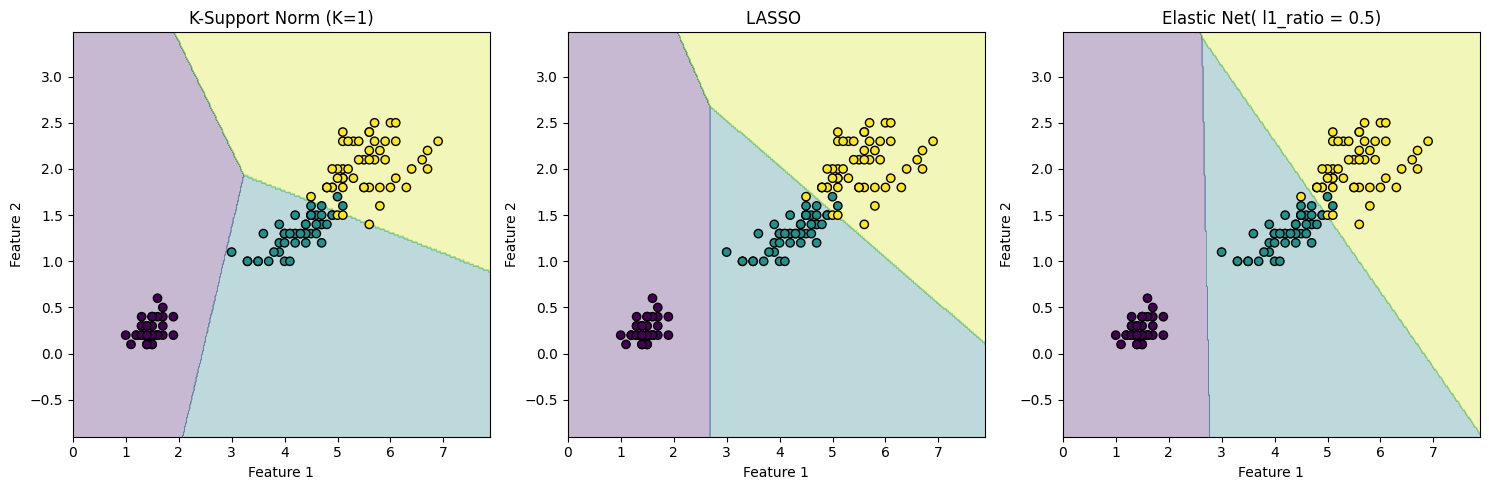

In [47]:
lr1 = LogisticRegression(multi_class='multinomial',penalty='l1' ,  solver='saga', max_iter=500)
lr1.fit(X_train, y_train)
print("LASSO Accuracy:", accuracy_score(y_test, lr1.predict(X_test)))
lr2 = LogisticRegression(multi_class='multinomial',penalty='elasticnet', l1_ratio=0.5 ,  solver='saga', max_iter=500)
lr2.fit(X_train, y_train)
print("Elastic Net Accuracy:", accuracy_score(y_test, lr2.predict(X_test)))
kmodel = K_Support_Norm(k=1, lambd=0.001, max_iter=10000)
kmodel.fit(X_train, y_train, num_classes, min_class_label)
ks_pred=kmodel.predict(X_test)
print("Accuracy score using k support norm:",accuracy_score(y_test, ks_pred))
plot_decision_boundary(kmodel, lr1, lr2, X, y)

### Yeast Type dataset

In [50]:
df = pd.read_csv('/content/yeast.csv')

In [51]:
df.shape

(1484, 9)

In [52]:
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [53]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

In [54]:
df['name'].value_counts()

,count
name,
CYT,463
NUC,429
MIT,244
ME3,163
ME2,51
ME1,44
EXC,35
VAC,30
POX,20


In [55]:
y_label = []
for i in range(len(y)):
  if y[i] == 'CYT':
    y_label.append(0)
  elif y[i] == 'NUC':
    y_label.append(1)
  elif y[i] == 'MIT':
    y_label.append(2)
  elif y[i] == 'ME3':
    y_label.append(3)
  else:
    y_label.append(4)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.2, random_state = 42)

In [57]:
X_train = np.hstack((X_train,np.ones((X_train.shape[0],1))))
X_test = np.hstack((X_test,np.ones((X_test.shape[0],1))))

In [60]:
num_classes = len(np.unique(y_label))
min_class_label = np.min(y_label)
print('classes:',np.unique(y_label))
print('num classes:', num_classes, ', minimum class:', min_class_label)

classes: [0 1 2 3 4]
num classes: 5 , minimum class: 0


In [59]:
lr1 = LogisticRegression(multi_class='multinomial',penalty='l1' ,  solver='saga')
lr1.fit(X_train, y_train)
print("LASSO Accuracy:", accuracy_score(y_test, lr1.predict(X_test)))
lr2 = LogisticRegression(multi_class='multinomial',penalty='elasticnet', l1_ratio=0.5 ,  solver='saga')
lr2.fit(X_train, y_train)
print("Elastic Net Accuracy:", accuracy_score(y_test, lr2.predict(X_test)))
kmodel = K_Support_Norm(k=2, lambd=0.1, max_iter=1000)
kmodel.fit(X_train, y_train, num_classes, min_class_label)
ks_pred=kmodel.predict(X_test)
print("Accuracy score using k support norm:",accuracy_score(y_test, ks_pred))

LASSO Accuracy: 0.6296296296296297
Elastic Net Accuracy: 0.6195286195286195
Accuracy score using k support norm: 0.6397306397306397
